In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-10 16:15:01.977124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 16:15:02.745240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
txt_file = 'data/eng_pop_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

267385


In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [4]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue
    
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
    
print(len(corpus))
print(corpus[:10])

258458
['<start> get her name and get her number <end>', '<start> find out all of the things <end>', '<start> that we have in common <end>', '<start> never all the differences <end>', '<start> oh yeah <end>', '<start> meet her parents meet her brother <end>', '<start> then she starts sleepin <end>', '<start> over the crib on weekends <end>', '<start> like a real relationship oh no <end>', '<start> for me the stars are alignin <end>']


In [5]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 25000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)
    
    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f70eb269e50> 
 [[   2   53  130 ...    0    0    0]
 [   2  158   60 ...    0    0    0]
 [   2   16   18 ...    0    0    0]
 ...
 [   2 1527  256 ...    0    0    0]
 [   2  956   22 ...    0    0    0]
 [   2 1628   45 ...    0    0    0]]


In [7]:
tensor.shape

(258458, 33)

In [8]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : you
6 : the
7 : it
8 : me
9 : to
10 : t
11 : and
12 : my
13 : a
14 : s
15 : m
16 : that
17 : in
18 : we
19 : don
20 : oh


In [9]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (258458, 33)
소스문장 길이:  32
타겟문장 길이:  32


In [10]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (206766, 32)
Target Train 길이:  (206766, 32)
Source Test 길이:  (51692, 32)
Target Test 길이:  (51692, 32)


In [11]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-10 16:15:35.564967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


<_BatchDataset element_spec=(TensorSpec(shape=(256, 32), dtype=tf.int32, name=None), TensorSpec(shape=(256, 32), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 32), dtype=tf.int32, name=None), TensorSpec(shape=(256, 32), dtype=tf.int32, name=None))>


2024-04-10 16:15:35.602777: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 16:15:35.602940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 16:15:35.603701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [13]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [14]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 32, 25001), dtype=float32, numpy=
array([[[ 5.36265830e-03,  2.07408005e-03, -4.21474018e-04, ...,
         -1.36538874e-04,  3.08622769e-03, -2.67301174e-03],
        [ 1.66611616e-02, -3.34580522e-03,  5.71644679e-03, ...,
         -7.89109990e-03, -2.56822282e-03,  6.71669375e-03],
        [ 1.26260670e-03, -4.86757094e-03, -3.66755994e-05, ...,
          1.89689510e-02,  2.14281268e-02, -7.35665439e-03],
        ...,
        [-9.69724171e-03,  1.68628488e-02,  6.64016306e-02, ...,
         -4.95083332e-02, -8.55433103e-03,  1.14426063e-02],
        [ 2.86446493e-02, -3.32130268e-02,  3.29296552e-02, ...,
         -5.88418692e-02,  6.46236315e-02, -8.12891498e-02],
        [ 2.55881716e-02, -7.47687519e-02,  6.11494407e-02, ...,
         -9.81339291e-02, -4.07244917e-03, -8.15090835e-02]],

       [[ 5.36265830e-03,  2.07408005e-03, -4.21474018e-04, ...,
         -1.36538874e-04,  3.08622769e-03, -2.67301174e-03],
        [ 1.67269371e-02, -1.11267818e-02,  7

In [15]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,400,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    25,626,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,436,201 (135.18 MB)

 Trainable params: 35,436,201 (135.18 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

2024-04-10 16:15:51.707050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 16:15:51.707295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 16:15:51.707395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [18]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712765758.737196  422981 service.cc:145] XLA service 0x7f701c004220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712765758.737256  422981 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-10 16:15:58.791474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 16:15:59.308263: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712765760.608288  423055 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 1748 bytes spill stores, 2168 bytes spill loads

I0000 00:00:1712765761.021503  423055 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712765

807/807 ━━━━━━━━━━━━━━━━━━━━ 295s 354ms/step - loss: 1.4927
Epoch 2/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 356ms/step - loss: 0.9372
Epoch 3/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.8707
Epoch 4/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 356ms/step - loss: 0.8259
Epoch 5/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.7873
Epoch 6/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.7559
Epoch 7/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.7251
Epoch 8/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.6993
Epoch 9/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 356ms/step - loss: 0.6754
Epoch 10/10
807/807 ━━━━━━━━━━━━━━━━━━━━ 287s 355ms/step - loss: 0.6551


In [19]:
model.save('rnn_eng_pop.keras')
model.save('rnn_eng_pop.h5')

In [20]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']
    
    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break
        
    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '
        
    return generated

In [21]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i m gonna be the supermodel <end> '

In [22]:
generate_text(model, tokenizer, init_sentence = '<start> i', max_len = 50)

'<start> i m gonna be the supermodel <end> '

In [23]:
generate_text(model, tokenizer, init_sentence = '<start> i love')

'<start> i love you like that <end> '

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> love')

'<start> love me like you do <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> Love is')

'<start> love is an open door <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> love you ')

'<start> love you <end> '

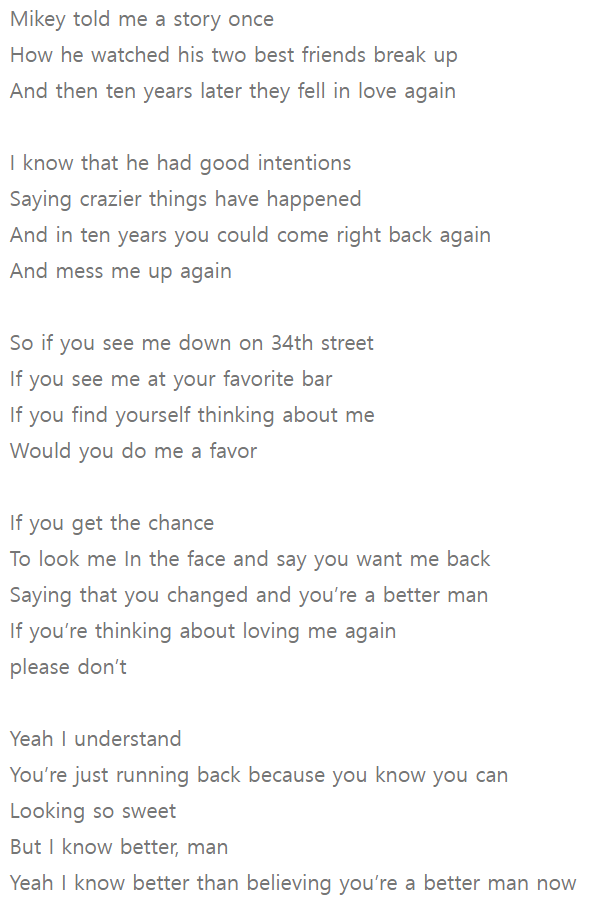

In [27]:
better_man = ['how', 'and', 'i', 'saying', 'so', 'if', 'would', 'to', 'please', 'you']
for word in better_man:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> how many times <end> 


<start> and i m gonna be the same <end> 
<start> i m gonna be the supermodel <end> 
<start> saying something to do <end> 
<start> so i ll be your light <end> 
<start> if you liked it <end> 
<start> would you love me less <end> 
<start> to be loved <end> 
<start> please don t leave me low <end> 
<start> you re the only one of me <end> 


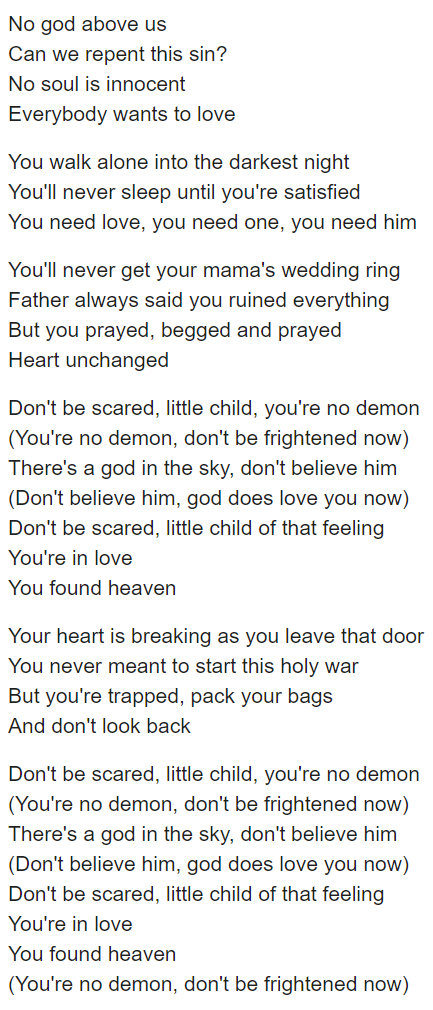

In [28]:
found_heaven = ['no', 'can', 'everybody', 'you', 'father', 'but', 'heart', 'don', 'there', 'your']
for word in found_heaven:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> no i don t want to be rude <end> 


<start> can t help but i don t know <end> 
<start> everybody knows <end> 
<start> you re the only one of me <end> 
<start> father said <end> 
<start> but i m not yours <end> 
<start> heart s a little bit <end> 
<start> don t be alarmed if i m in the wrong <end> 
<start> there s no place <end> 
<start> your love s a permanent <end> 
